In [1]:
from dataclasses import dataclass, field
import numpy as np
from numpy import ndarray
from skimage import io
from pathlib import Path
from tkinter import Tk
from tkinter.filedialog import askopenfilename, asksaveasfilename
from tifffile import imwrite
from matplotlib import pyplot as plt


def gui_get_filepath() -> Path:
    """Get a path via a native GUI"""
    root = Tk()
    p = Path(askopenfilename(parent=root))
    root.withdraw()
    return p


def gui_save_tiff(img, default_fname: str|None = None)  -> None:
    root = Tk()
    fname = asksaveasfilename(confirmoverwrite=True, parent=root, initialfile=default_fname, defaultextension=".tif")
    imwrite(fname, img, photometric='minisblack')
    root.withdraw()


@dataclass(frozen=False)
class DPC:
    # User defined
    rot: float
    flip_y: bool
    AC: ndarray
    BD: ndarray
    iDPC_filter: float
    # Calculated
    iDPC: ndarray = field(init=False)
    dDPC: ndarray = field(init=False)


    def __post_init__(self):
        # Normalize input images and store in the class
        AC_normed: ndarray = ((self.AC - np.min(self.AC)) /
                                   (np.max(self.AC) - np.min(self.AC)))
        BD_normed: ndarray = ((self.BD - np.min(self.BD)) /
                                   (np.max(self.BD) - np.min(self.BD)))

        # Calculate DPC components from difference images
        if not self.flip_y:
            DPC_x: ndarray = (AC_normed*np.cos(self.rot)
                              - BD_normed*np.sin(self.rot))
            DPC_y: ndarray = (AC_normed*np.sin(self.rot)
                              + BD_normed*np.cos(self.rot))
        elif self.flip_y:
            DPC_x: ndarray = (AC_normed*np.cos(self.rot)
                              + BD_normed*np.sin(self.rot))
            DPC_y: ndarray = (AC_normed*np.sin(self.rot)
                              - BD_normed*np.cos(self.rot))
        else:
            raise RuntimeError("self.flip_y evaluates to neither True nor False")

        # Calculate and store iDPC
        freq_x = np.fft.fftfreq(DPC_x.shape[-1], 1)
        freq_y = np.fft.fftfreq(DPC_x.shape[-2], 1)
        k = np.meshgrid(freq_x, freq_y)
        freqs = np.hypot(k[0], k[1])
        angle = np.arctan2(k[1], k[0])
        radi = np.where(freqs > self.iDPC_filter, freqs, 0)
        k_sq = np.where(radi > 0, radi**2, 1)
        iDPC_x = np.real(np.fft.ifft2((np.fft.fft2(DPC_x) * radi * np.cos(angle))
                                     / (2*np.pi*1j*k_sq)))
        iDPC_y = np.real(np.fft.ifft2((np.fft.fft2(DPC_y)*radi*np.sin(angle))
                                     / (2*np.pi*1j*k_sq)))
        iDPC = (iDPC_x+iDPC_y)
        iDPC = ((iDPC - np.min(iDPC))
                /(np.max(iDPC) - np.min(iDPC)))
        self.iDPC = iDPC.astype("float32")

        # Calculate and store dDPC
        grad_x = np.gradient(DPC_x, axis=-1)
        grad_y = np.gradient(DPC_y, axis=-2)
        dDPC = -(grad_x + grad_y)
        dDPC = ((dDPC - np.min(dDPC))
                / (np.max(dDPC) - np.min(dDPC)))
        self.dDPC = dDPC.astype("float32")

In [ ]:
# Run this cell to load individual quadrant image data
quad_A: ndarray = io.imread(gui_get_filepath(), as_gray=True).astype("float64")
quad_B: ndarray = io.imread(gui_get_filepath(), as_gray=True).astype("float64")
quad_C: ndarray = io.imread(gui_get_filepath(), as_gray=True).astype("float64")
quad_D: ndarray = io.imread(gui_get_filepath(), as_gray=True).astype("float64")

diff_AC: ndarray = quad_A - quad_C
diff_BD: ndarray = quad_B - quad_D

In [8]:
# Run this cell to load difference image data
# Warning: this will overwrite data loaded by the previous cell, only run one or the other!
# noinspection PyRedeclaration
diff_AC: ndarray = io.imread(gui_get_filepath(), as_gray=True).astype("float64")
# noinspection PyRedeclaration
diff_BD: ndarray = io.imread(gui_get_filepath(), as_gray=True).astype("float64")

In [9]:
# Settings
detector_rotation: float = -132  # Degrees; Themis has -132, sims from DrProbe w/ my defaults have 45
scan_rotation: float = -54.9  # Degrees; usually zero unless changed during microscope session
flip_y: bool = True  # Sometimes the y-axis is flipped relative to the ndarray; set to True to account for this
idpc_filter: float = 0.008  # Filter width to remove low frequencies from iDPC (must be > 0)

In [10]:
rotrad: float = np.deg2rad(detector_rotation + scan_rotation)
dpc = DPC(rotrad, flip_y, diff_AC, diff_BD, idpc_filter)

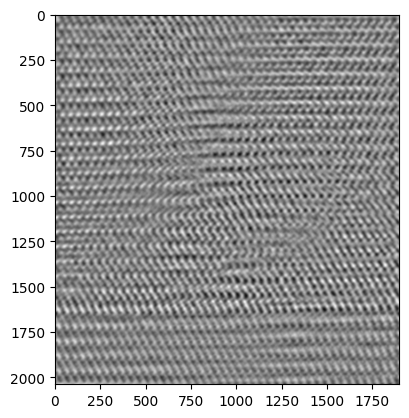

In [11]:
plt.imshow(dpc.iDPC, cmap="binary")

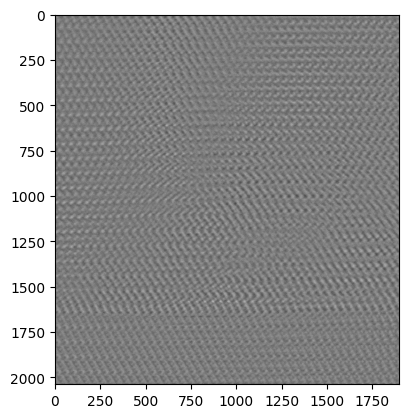

In [12]:
plt.imshow(dpc.dDPC, cmap="binary")

In [13]:
gui_save_tiff(dpc.iDPC, "iDPC.tif")
gui_save_tiff(dpc.dDPC, "dDPC.tif")